# NorSWE Large Sample Experiment Tutorial

This notebook demonstrates how to run CONFLUENCE over multiple snow observation sites from the NorSWE dataset.

## Overview

NorSWE provides snow observations (snow water equivalent and snow depth) from a network of stations across the northern hemisphere. Running CONFLUENCE at these sites allows us to:

- Validate snow modeling in Nordic conditions
- Compare model performance across different elevations and climates
- Test model physics in snow-dominated environments
- Analyze mountain snow processes

## 1. Setup and Imports

In [1]:
import sys
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import yaml
from datetime import datetime
import xarray as xr
import seaborn as sns

# Add CONFLUENCE to path
confluence_path = Path('../').resolve()
sys.path.append(str(confluence_path))

# Set up plotting style
plt.style.use('default')
sns.set_palette("coolwarm")
%matplotlib inline

print("Setup complete!")

Setup complete!


## 2. Configure the Experiment

In [2]:
# Configuration for the NorSWE large sample experiment
experiment_config = {
    'experiment_name': 'norswe_tutorial',
    'norswe_path': '/work/comphyd_lab/data/geospatial-data/NorSWE/NorSWE-NorEEN_1979-2021_v2.nc',
    'template_config': '../CONFLUENCE/0_config_files/config_norswe_template.yaml',
    'config_dir': '../CONFLUENCE/0_config_files/norswe',
    'output_dir': './norswe_output',
    'base_path': '/work/comphyd_lab/data/CONFLUENCE_data/norswe',
    'min_completeness': 0.0,  # Minimum % data completeness
    'max_stations': 10,  # Number of stations to process
    'start_year': 2010,  # Optional: filter data by year
    'end_year': 2020,
    'no_submit': False  # Set to True for dry run
}

# Create directories
experiment_dir = Path(f"./experiments/{experiment_config['experiment_name']}")
experiment_dir.mkdir(parents=True, exist_ok=True)
Path(experiment_config['output_dir']).mkdir(parents=True, exist_ok=True)
Path(experiment_config['config_dir']).mkdir(parents=True, exist_ok=True)

# Save configuration
with open(experiment_dir / 'experiment_config.yaml', 'w') as f:
    yaml.dump(experiment_config, f)

print(f"Experiment configured: {experiment_config['experiment_name']}")
print(f"Processing up to {experiment_config['max_stations']} NorSWE stations")

Experiment configured: norswe_tutorial
Processing up to 10 NorSWE stations


## 3. Explore NorSWE Dataset

In [ ]:
'''
# Open NorSWE dataset
ds = xr.open_dataset(experiment_config['norswe_path'])

print("NorSWE Dataset Information:")
print(f"Time range: {ds.time.values[0]} to {ds.time.values[-1]}")
print(f"Number of stations: {len(ds.station_id)}")
print(f"Variables: {list(ds.data_vars)}")
print(f"Coordinates: {list(ds.coords)}")

# Display dataset structure
print("\nDataset structure:")
print(ds)

ds.close()
'''

## 4. Process NorSWE Station Data

In [6]:
# Import the processing function from the script
sys.path.append(str(confluence_path / '9_scripts'))
from run_sites_norswe import process_norswe_data

# Process station data
stations_csv = Path('norswe_stations.csv')
stations_df = pd.read_csv(stations_csv)

'''
stations_df = process_norswe_data(
    experiment_config['norswe_path'],
    str(stations_csv),
    start_year=experiment_config.get('start_year'),
    end_year=experiment_config.get('end_year'),
    use_existing_csv=True
)
'''

print(f"Processed {len(stations_df)} stations")
print("\nStation data columns:")
for col in stations_df.columns:
    print(f"  - {col}")

# Display sample stations
print("\nSample stations:")
display(stations_df[['station_id', 'station_name', 'lat', 'lon', 'elevation', 'swq_completeness']].head())


Processed 10118 stations

Station data columns:
  - station_id
  - station_name
  - lat
  - lon
  - elevation
  - source
  - type_mes
  - mmask
  - is_snotel
  - swq_valid_count
  - snd_valid_count
  - swq_completeness
  - snd_completeness
  - BOUNDING_BOX_COORDS
  - POUR_POINT_COORDS
  - Watershed_Name

Sample stations:


,station_id,station_name,lat,lon,elevation,swq_completeness
0,CanSWE-ALE-05AA805,WEST CASTLE SNOW,49.266666,-114.350000,1525.0,0.047936
1,CanSWE-ALE-05AA806,RACE HORSE CREEK,49.816666,-114.633330,1920.0,0.159785
2,CanSWE-ALE-05AD802,MIDDLE DRYWOOD,49.250000,-114.050000,1570.0,0.022370
3,CanSWE-ALE-05AE810,\LEE CREEK \\P\\\,49.033333,-113.566666,1525.0,0.054327
4,CanSWE-ALE-05AE811,\LEE CREEK \\D\\\,49.016666,-113.616670,1660.0,0.051131


## 5. Visualize Station Distribution

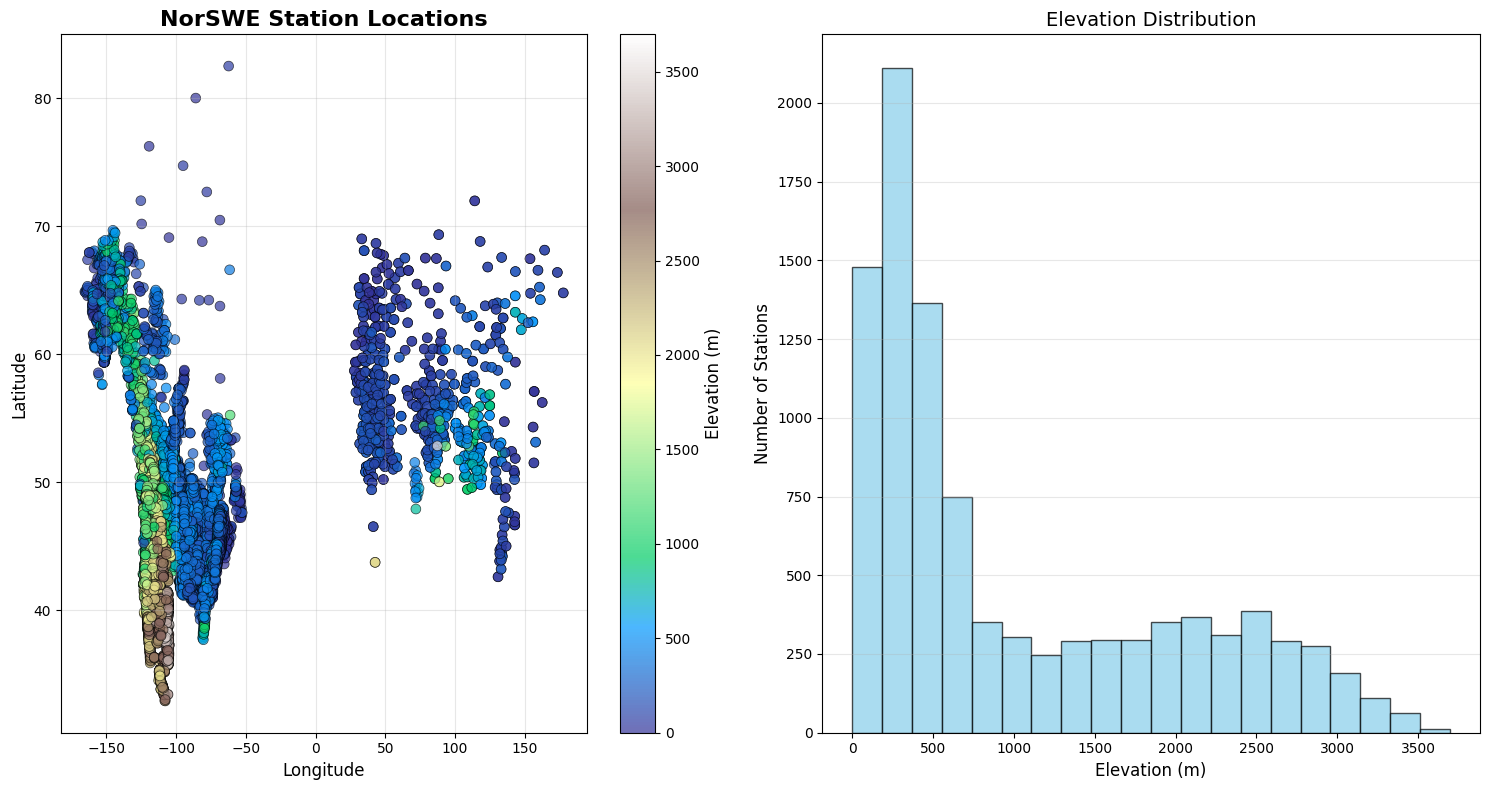

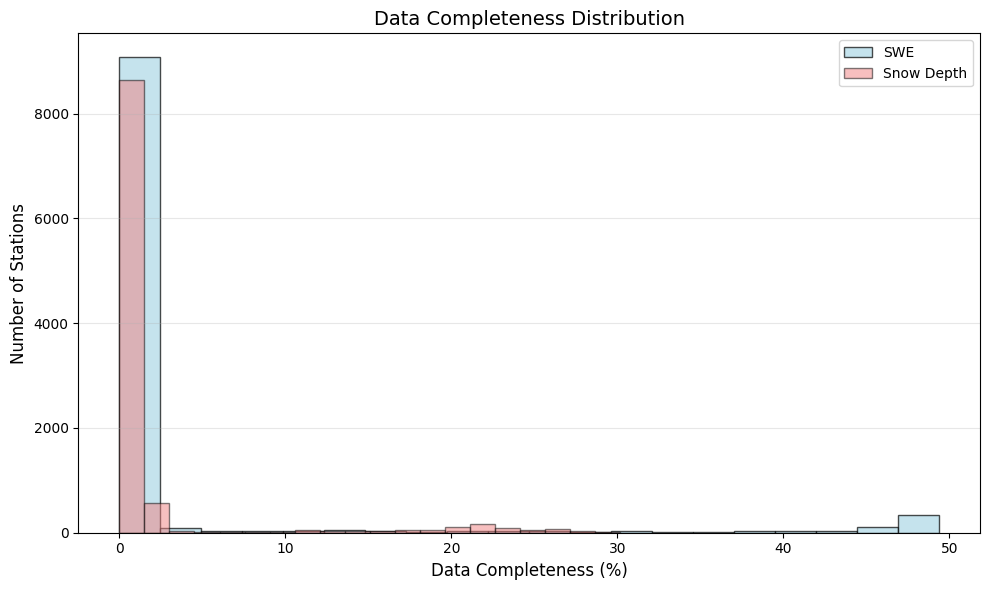

In [7]:
# Create station distribution map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Geographic distribution
scatter = ax1.scatter(stations_df['lon'], stations_df['lat'], 
                     c=stations_df['elevation'], cmap='terrain',
                     s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
ax1.set_title('NorSWE Station Locations', fontsize=16, fontweight='bold')
ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)
ax1.grid(True, alpha=0.3)

# Add colorbar for elevation
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Elevation (m)', fontsize=12)

# Elevation distribution
ax2.hist(stations_df['elevation'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Elevation (m)', fontsize=12)
ax2.set_ylabel('Number of Stations', fontsize=12)
ax2.set_title('Elevation Distribution', fontsize=14)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Data completeness distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(stations_df['swq_completeness'], bins=20, color='lightblue', 
        edgecolor='black', alpha=0.7, label='SWE')
ax.hist(stations_df['snd_completeness'], bins=20, color='lightcoral', 
        edgecolor='black', alpha=0.5, label='Snow Depth')
ax.set_xlabel('Data Completeness (%)', fontsize=12)
ax.set_ylabel('Number of Stations', fontsize=12)
ax.set_title('Data Completeness Distribution', fontsize=14)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Select Stations for Processing

In [8]:
# Filter stations by data completeness
complete_stations = stations_df[
    (stations_df['swq_completeness'] >= experiment_config['min_completeness']) &
    (stations_df['snd_completeness'] >= experiment_config['min_completeness'])
].copy()

print(f"Found {len(complete_stations)} stations with ≥{experiment_config['min_completeness']}% completeness")

# Select stations (prioritize by completeness and elevation diversity)
if len(complete_stations) > experiment_config['max_stations']:
    # Sort by completeness and select diverse elevations
    complete_stations = complete_stations.sort_values(
        by=['swq_completeness', 'snd_completeness'], 
        ascending=False
    ).head(experiment_config['max_stations'])

print(f"\nSelected {len(complete_stations)} stations for processing")
display(complete_stations[['station_id', 'station_name', 'elevation', 'swq_completeness']])

# Save selected stations
complete_stations.to_csv(experiment_dir / 'selected_stations.csv', index=False)

Found 10118 stations with ≥0.0% completeness

Selected 10 stations for processing


,station_id,station_name,elevation,swq_completeness
9368,SNOTEL-400,CLEAR CREEK #2,2388.7466,49.373642
9853,SNOTEL-924,WEST YELLOWSTONE,2042.1848,49.370446
9759,SNOTEL-813,TEPEE CREEK,2438.4297,49.357663
9350,SNOTEL-381,CALVERT CREEK,1959.8878,49.354468
9281,SNOTEL-311,BANFIELD MOUNTAIN,1706.9008,49.351272
9803,SNOTEL-858,WHISKEY CREEK,2072.6653,49.348076
9330,SNOTEL-360,BOULDER MOUNTAIN,2423.1895,49.341685
9710,SNOTEL-760,SKALKAHO SUMMIT,2209.8270,49.338489
9736,SNOTEL-787,STAHL PEAK,1837.9663,49.335293
9527,SNOTEL-568,LAKEVIEW RIDGE,2255.5474,49.328902


## 7. Extract Snow Observation Data

In [ ]:
'''
# Example: Extract and plot snow data for one station
from run_sites_norswe import extract_snow_data

# Select first station as example
example_station = complete_stations.iloc[0]
station_id = example_station['station_id']
station_name = example_station['Watershed_Name']

# Create output directory for this station
station_dir = Path(experiment_config['base_path']) / f"domain_{station_name}"
station_dir.mkdir(parents=True, exist_ok=True)

# Extract snow data
swe_file, snd_file = extract_snow_data(
    experiment_config['norswe_path'],
    station_id,
    str(station_dir),
    start_year=experiment_config.get('start_year'),
    end_year=experiment_config.get('end_year')
)

# Load and visualize the extracted data
swe_df = pd.read_csv(swe_file)
snd_df = pd.read_csv(snd_file)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot SWE
ax1.plot(pd.to_datetime(swe_df['time']), swe_df['SWE_kg_m2'], 
         color='blue', linewidth=1.5, alpha=0.7)
ax1.set_ylabel('SWE (kg/m²)', fontsize=12)
ax1.set_title(f'Snow Observations - {station_name} (ID: {station_id})', fontsize=14)
ax1.grid(True, alpha=0.3)

# Plot snow depth
ax2.plot(pd.to_datetime(snd_df['time']), snd_df['Depth_m'] * 100, 
         color='purple', linewidth=1.5, alpha=0.7)
ax2.set_ylabel('Snow Depth (cm)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Extracted snow data for {station_name}:")
print(f"  SWE file: {swe_file}")
print(f"  Snow depth file: {snd_file}")
'''

## 8. Generate Configuration Files

In [ ]:
'''
# Generate configs for selected stations
from run_sites_norswe import generate_config_file

config_dir = Path(experiment_config['config_dir'])
generated_configs = []

for _, station in complete_stations.iterrows():
    station_name = station['Watershed_Name']
    pour_point = station['POUR_POINT_COORDS']
    bounding_box = station['BOUNDING_BOX_COORDS']
    
    # Generate config file
    config_path = config_dir / f"config_{station_name}.yaml"
    
    generate_config_file(
        experiment_config['template_config'],
        str(config_path),
        station_name,
        pour_point,
        bounding_box
    )
    
    generated_configs.append(config_path)

print(f"Generated {len(generated_configs)} configuration files")
print("\nExample config locations:")
for config in generated_configs[:3]:
    print(f"  - {config}")
'''

## 9. Launch CONFLUENCE Jobs

In [ ]:
'''
# Prepare to launch CONFLUENCE runs
from run_sites_norswe import run_confluence

submitted_jobs = []
skipped_jobs = []

# Interactive decision (for notebook, we'll simulate 'y' or 'n')
if experiment_config['no_submit']:
    submit_jobs = 'n'
    print("DRY RUN MODE - No jobs will be submitted")
else:
    submit_jobs = 'y'  # In real notebook, you'd ask user
    print("Preparing to submit CONFLUENCE jobs...")

if submit_jobs == 'y':
    for _, station in complete_stations.iterrows():
        station_name = station['Watershed_Name']
        
        # Check if simulation already exists
        sim_path = Path(experiment_config['base_path']) / f"domain_{station_name}" / "simulations" / "run_1" / "SUMMA" / "run_1_timestep.nc"
        
        if sim_path.exists():
            print(f"Skipping {station_name} - simulation already exists")
            skipped_jobs.append(station_name)
            continue
        
        # Submit job
        config_path = config_dir / f"config_{station_name}.yaml"
        job_id = run_confluence(str(config_path), station_name)
        
        if job_id:
            submitted_jobs.append((station_name, job_id))
            print(f"Submitted job for {station_name}: {job_id}")
        
        # Small delay between submissions
        import time
        time.sleep(2)

# Summary
print("\nJob submission summary:")
print(f"  Submitted: {len(submitted_jobs)}")
print(f"  Skipped: {len(skipped_jobs)}")

if submitted_jobs:
    print("\nSubmitted jobs:")
    for station_name, job_id in submitted_jobs[:5]:
        print(f"  {station_name}: {job_id}")
'''

## 10. Monitor Job Status

In [ ]:
'''
# Check job status
def check_job_status(user=None):
    user = user or os.environ.get('USER')
    cmd = ['squeue', '-u', user]
    result = subprocess.run(cmd, capture_output=True, text=True)
    return result.stdout

print("Current job status:")
print(check_job_status())

# Save job information
if submitted_jobs:
    job_df = pd.DataFrame(submitted_jobs, columns=['station_name', 'job_id'])
    job_df.to_csv(experiment_dir / 'submitted_jobs.csv', index=False)
    print(f"\nJob information saved to {experiment_dir / 'submitted_jobs.csv'}")
'''

## 11. Find Completed Simulations

In [10]:
# Find completed simulations
base_path = Path(experiment_config['base_path'])
completed = []

for _, station in complete_stations.iterrows():
    station_name = station['Watershed_Name']
    sim_path = base_path / f"domain_{station_name}" / "simulations" / "run_1" / "SUMMA"
    
    if sim_path.exists() and list(sim_path.glob("*timestep*.nc")):
        completed.append({
            'station_name': station_name,
            'station_id': station['station_id'],
            'elevation': station['elevation'],
            'sim_path': sim_path
        })

print(f"Found {len(completed)} completed simulations")
if completed:
    completed_df = pd.DataFrame(completed)
    display(completed_df[['station_name', 'station_id', 'elevation']])

Found 10 completed simulations


,station_name,station_id,elevation
0,SNOTEL_400,SNOTEL-400,2388.7466
1,SNOTEL_924,SNOTEL-924,2042.1848
2,SNOTEL_813,SNOTEL-813,2438.4297
3,SNOTEL_381,SNOTEL-381,1959.8878
4,SNOTEL_311,SNOTEL-311,1706.9008
5,SNOTEL_858,SNOTEL-858,2072.6653
6,SNOTEL_360,SNOTEL-360,2423.1895
7,SNOTEL_760,SNOTEL-760,2209.8270
8,SNOTEL_787,SNOTEL-787,1837.9663
9,SNOTEL_568,SNOTEL-568,2255.5474


## 12. Load and Compare Results

/tmp/ipykernel_1208389/534169386.py:35: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  ax.plot(model_data['time'], model_data['swe'],
/tmp/ipykernel_1208389/534169386.py:35: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  ax.plot(model_data['time'], model_data['swe'],
/tmp/ipykernel_1208389/534169386.py:35: MatplotlibDeprecationWarning: Passing label as a length 4 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  ax.plot(model_data['time'], model_data['swe'],
/tmp/ipykernel_1208389/534169386.py:35: Matplo

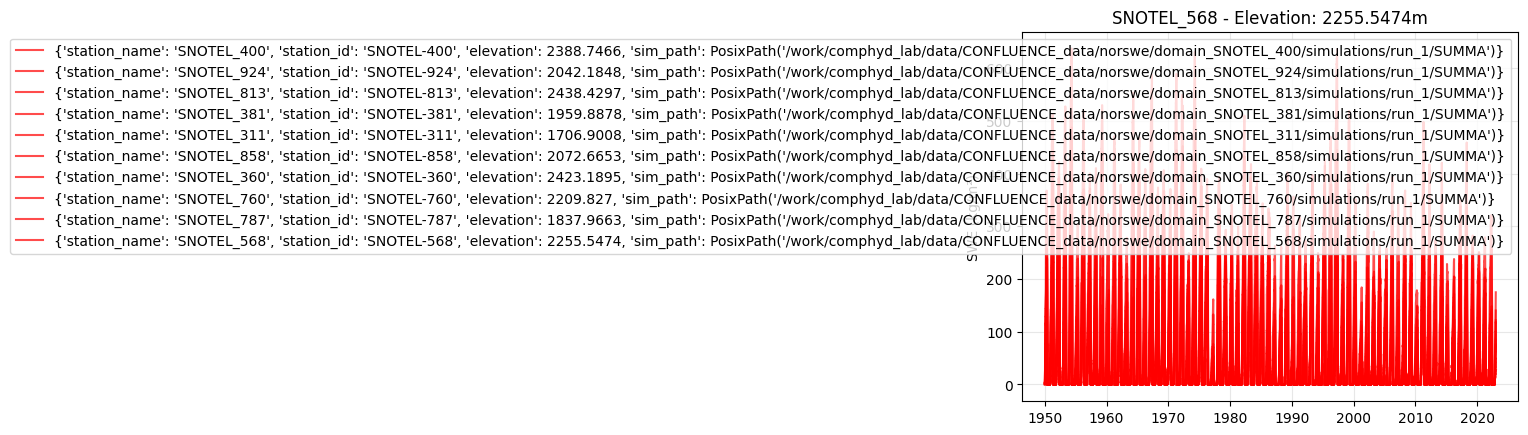

In [19]:
# Function to load SUMMA snow output
def load_summa_snow(sim_path):
    output_files = list(Path(sim_path).glob("*day*.nc"))
    if output_files:
        ds = xr.open_dataset(output_files[0])
        
        # Extract SWE and snow depth if available
        data = {}
        if 'scalarSWE' in ds.variables:
            data['swe'] = ds.scalarSWE.values.flatten()
        if 'scalarSnowDepth' in ds.variables:
            data['depth'] = ds.scalarSnowDepth.values.flatten()
        
        data['time'] = pd.to_datetime(ds.time.values)
        ds.close()
        
        return pd.DataFrame(data)
    return None

# Compare modeled and observed snow for completed simulations
if completed:
    fig, ax = plt.subplots()
    
    for i, site in enumerate(completed[:30]):
        # Load model output
        model_data = load_summa_snow(site['sim_path'])
        
        # Load observations
        #obs_path = base_path / f"domain_{site['station_name']}" / "observations" / "snow" / "raw_data"
        #swe_obs = pd.read_csv(obs_path / "swe" / f"{site['station_id']}_swe.csv")
        #snd_obs = pd.read_csv(obs_path / "depth" / f"{site['station_id']}_depth.csv")
        
        if model_data is not None:
            if 'swe' in model_data:
                ax.plot(model_data['time'], model_data['swe'], 
                        'r-', label=site, alpha=0.7)
            ax.set_ylabel('SWE (kg/m²)')
            ax.set_title(f"{site['station_name']} - Elevation: {site['elevation']}m")
            ax.legend()
            ax.grid(True, alpha=0.3)
        
    
    plt.tight_layout()
    plt.show()

## 13. Performance Analysis Across Elevations